In [6]:
from modeling.compute import Var
from modeling.execution import Component, edges_from_components
from graph.operators import invert_edges, sort_scc
from graph.graphutils import flat_graph_formulation
from graph.graphutils import edges_E, all_edges
from graph.graphutils import all_variables
from graph.graphview import draw
from graph.matrixview import render_incidence
from graph.operators import eqv_to_edges_tree
from collections import OrderedDict
import numpy as np

In [7]:
a = Var('a')
b = Var('b')
c = Var('c', 10)
d = Var('d', 20)

In [8]:
eqlist = [(b, c+1), (a, b-2), (a, 2*d+3)]

In [9]:
components = [Component.fromsympy(
    right, left, component=idx) for idx, (left, right) in enumerate(eqlist)]
edges = edges_from_components(components)

In [10]:
from modeling.transformations import flatten_component
rescomps = list(map(flatten_component, components))
rescomps

[(('c', 'b'), 0, (None,), 'b-(c + 1)'),
 (('b', 'a'), 1, (None,), 'a-(b - 2)'),
 (('d', 'a'), 2, (None,), 'a-(2*d + 3)')]

In [11]:
components[0].function(11)

[DeviceArray(12., dtype=float64)]

In [12]:
rescomps[2].graddict({'a':1,'d':1})

{'d': DeviceArray(-2., dtype=float64), 'a': DeviceArray(1., dtype=float64)}

In [13]:
residuals = invert_edges(edges[0], edges[1]) #{0: 'b', 1:'a'}

In [14]:
edges_left_right = all_edges(edges[0], edges[1])
edges_varonleft = edges_E(residuals[0])
outset = {key:var[0] for key,var in edges[1].items()}
eqnidxs= outset.keys()
varidxs = all_variables(edges[0], edges[1])

In [15]:
from presolver.tearing import min_arc_set_assign

In [16]:
fixed_inputs = set(varidxs)-set(outset.values())
xsol, model  = min_arc_set_assign(edges_varonleft, varidxs, eqnidxs, not_output=fixed_inputs)
outset_minassign = dict((right, left) for left, right in edges_varonleft if xsol[left, right] > 0.5)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-07


In [17]:
edges_minassign=invert_edges(edges[0], edges[1], outset_minassign) 

In [18]:
edges_minassign

({0: ('c',), 1: ('b',), 2: ('d', 'a')}, {0: ('b',), 1: ('a',), 2: (None,)}, {})

In [19]:
tree = (OrderedDict([(0,1),(1,1),(2,1)]),{},{})

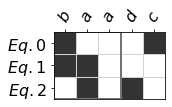

In [20]:
render_incidence(edges, tree, 
                 rawvarname=True, 
                 figsize=(2,2),
                 diagonalgray=False);

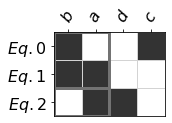

In [21]:
render_incidence(edges_minassign, tree, 
                 rawvarname=True, 
                 figsize=(2,2),
                 diagonalgray=False, patchwidth=3);

In [22]:
from graph.graphutils import Node, COMP
import networkx as nx
G = flat_graph_formulation(*edges)
matching = nx.bipartite.maximum_matching(G)
m_out = {key: matching[Node(key, COMP)].name for key in eqnidxs}
merge_order = sort_scc(G)

In [23]:
invert_edges(edges[0], edges[1], m_out) 

({0: ('b',), 1: ('a',), 2: ('a',)}, {0: ('c',), 1: ('b',), 2: ('d',)}, {})

In [24]:
from trash.inputresolver import idx_eqlist, eqvars
from trash.inputresolver import default_in, default_out
from trash.inputresolver import mdf_order
from graph.graphview import bipartite_repr

In [25]:
eqs = idx_eqlist(eqlist)
eqv = eqvars(eqs)

In [26]:
dout = default_out(eqs)

In [27]:
ins = default_in(eqs)
ins

{c, d}

In [28]:
B, edge = bipartite_repr(eqv)

In [29]:
M = nx.bipartite.maximum_matching(B)

In [30]:
M

{d: 2, c: 0, a: 1, 0: c, 1: a, 2: d}

In [31]:
order = mdf_order(eqv, M)

In [32]:
order

[0, 1, 2]

In [33]:
solve_order = ([0,1],2)

In [34]:
compute_order([],solve_order);

    create group:  0.1
    create system solver for  0.1
      create group:  0.1.2
      default sequential solver for  0.1.2
        add to  0.1.2  eq:  0
        add to  0.1.2  eq:  1
      add to  0.1  eq:  2


In [35]:
# prob = om.Problem()
# model = prob.model
# counter = coupled_run(eqs, [], solve_order, model, model, 0)
# buildidpvars(ins, model)
# prob.setup()
# prob.run_model()

In [36]:
(b-(c+1))

b - c - 1

In [37]:
ev = Component.fromsympy(b-(c+1))

In [38]:
ev.evaldict({'b':1,'c':2})

-2

In [39]:
A = np.array([[0, 1, -1],[1, -1, 0],[1, 0, 0]])
B = np.array([1, -2, 5])
np.linalg.solve(A, B)

array([5., 7., 6.])

In [40]:
[rescomp.evaldict({'a':5,'b':7,'c':6,'d':1}) for rescomp in rescomps]

[[DeviceArray([0.], dtype=float64)],
 [DeviceArray([0.], dtype=float64)],
 [DeviceArray([0.], dtype=float64)]]

In [41]:
vrs = all_variables(edges[0], edges[1])

In [42]:
from foundations.functionalsets import ResidualSet
from foundations.functionalsets import FunctionalComp
from foundations.functionalsets import DefaultResidualSolver
components = [Component.fromsympy(right, left, 
                                  component=idx, arg_mapping=True) 
                                  for idx, (left, right) in enumerate(eqlist)]
functionals = [FunctionalComp(comp) for comp in components]
S = ResidualSet(sum([functional.projectable.components for functional in functionals], []))
F = S.project([d])

In [43]:
F.solve({d: 1})

{c: 6.0, b: 7.0, a: 5.0}

In [44]:
import openmdao.api as om
from solver.postprocess import print_output_mdao

In [45]:
class ImpWithInitial(om.ImplicitComponent):
    def initialize(self):
        self.options.declare('residuals')
        self.options.declare('solvefor')
        self.options.declare('inputs')
        
    def setup(self):
        solvefor = self.options['solvefor']
        inputs = self.options['inputs']
        for input in inputs:
            self.add_input(input)
        for output in solvefor:
            self.add_output(output, val=0.1)
        self.declare_partials(of='*', wrt='*')

    def apply_nonlinear(self, inputs, outputs, residuals):
        solvefor_vars = self.options['solvefor']
        input_vars = self.options['inputs']
        rescomps = self.options['residuals']
        d = {elt: inputs[elt] for elt in input_vars}
        d.update({elt: outputs[elt] for elt in solvefor_vars})
        for solve_var,rescomp in zip(solvefor_vars, rescomps):
            residuals[solve_var] = rescomp.evaldict(d)
        
    def linearize(self, inputs, outputs, partials):
        solvefor_vars = self.options['solvefor']
        input_vars = self.options['inputs']
        rescomps = self.options['residuals']
        d = {elt: inputs[elt] for elt in input_vars}
        d.update({elt: outputs[elt] for elt in solvefor_vars})
        for solve_var,rescomp in zip(solvefor_vars, rescomps):
            J = rescomp.graddict(d)
            partials[solve_var, solve_var] = 0
            for varname in solvefor_vars:
                partials[solve_var, varname] = J.get(varname, 0)
        
prob = om.Problem()
model = prob.model

model.add_subsystem('comp', ImpWithInitial(
    residuals=rescomps, solvefor={'a','b','c'}, inputs={'d'}), promotes=['*'])
model.nonlinear_solver = om.NewtonSolver(solve_subsystems=False)
model.linear_solver = om.ScipyKrylov()

prob.setup()
prob.run_model()

NL: Newton Converged in 1 iterations


In [46]:
print_output_mdao(prob)

c:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\system.py:136: OMDeprecationWarning:The metadata key 'value' will be deprecated in 4.0. Please use 'val'.


{'c': 6.0, 'a': 5.0, 'b': 7.0}